In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/lob-msft/ShuffleEncoder.pickle
/kaggle/input/lob-msft/After_Process_Data.csv
/kaggle/input/lob-msft/SeqGAN_output.txt
/kaggle/input/lob-msft/SeqGAN_input_may_7.txt
/kaggle/input/lob-msft/SeqGAN_output_may_7.txt
/kaggle/input/lob-msft/OrdinalEncoder.pickle
/kaggle/input/lob-msft/MSFT_2012-06-21_34200000_57600000_message_1.csv
/kaggle/input/lob-msft/MSFT_2012-06-21_34200000_57600000_orderbook_1.csv
/kaggle/input/lob-msft/SeqGAN_input.txt
/kaggle/input/lob-msft/LOBSTER_SampleFiles_ReadMe.txt


In [2]:
# ! git clone https://github.com/geek-ai/Texygen.git

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling 
import plotly.express as px

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from random import sample

import pickle

In [4]:
# class MultiColumnLabelEncoder:
#     def __init__(self,columns = None):
#         self.columns = columns # array of column names to encode

#     def fit(self,X,y=None):
#         return self # not relevant here

#     def transform(self,X):
#         '''
#         Transforms columns of X specified in self.columns using
#         LabelEncoder(). If no columns specified, transforms all
#         columns in X.
#         '''
#         output = X.copy()
#         if self.columns is not None:
#             for col in self.columns:
#                 output[col] = LabelEncoder().fit_transform(output[col])
#         else:
#             for colname,col in output.iteritems():
#                 output[colname] = LabelEncoder().fit_transform(col)
#         return output

#     def fit_transform(self,X,y=None):
#         return self.fit(X,y).transform(X)
    
def get_index_list(cat_num_list):
    '''
    e.g. 
    input: [4,5,6]
    output: [30,6,1]
    '''
    reverse_num_list = cat_num_list[::-1]
    index_list_reverse = []
    count = 1
    for i in reverse_num_list:
        index_list_reverse.append(count)
        count *= i
    index_list = index_list_reverse[::-1]
    return index_list
    
def encode_cat(data_list,cat_num_list):
    '''
    from [1,1,1] & [4,5,6] to get index 37
    '''
    index_list = get_index_list(cat_num_list)
    return np.dot(data_list,index_list)

def decode_cat(index,cat_num_list):
    '''
    from index 37 to get [1,1,1] given [4,5,6]
    '''
    index_list = get_index_list(cat_num_list)
    data_list = []
    for i in index_list:
        num = index // i
        data_list.append(num)
        index -= num * i
    return data_list

In [5]:
import random
class Shuffle_Transformer:
    def __init__(self,index):
        self.index = index
        index_2 = index.copy()
        random.shuffle(index_2)
        self.shuffle_index = index_2
        self.index_map = dict(zip(self.index,self.shuffle_index))
        self.inverse_index_map = {v: k for k, v in self.index_map.items()}  
    def get_index_map(self):
        return self.index_map
    def get_shuffle(self,lst):
        y = list(map(self.index_map.get, lst))
        return y
    def get_inverse(self,lst):
        z = list(map(self.inverse_index_map.get, lst))
        return z
    
from sklearn.preprocessing import OrdinalEncoder
# test_block = message.iloc[0:10,:]
# feature_encoder = OrdinalEncoder()
# feature_encoder.fit(test_block[['Type','Direction']])
# new = test_block.copy()
# new[['Type','Direction']] = feature_encoder.transform(test_block[['Type','Direction']])

In [6]:
# Change it
massege_file = "/kaggle/input/lob-msft/MSFT_2012-06-21_34200000_57600000_message_1.csv"
order_file = "/kaggle/input/lob-msft/MSFT_2012-06-21_34200000_57600000_orderbook_1.csv"
message= pd.read_csv(massege_file,header=None,names=['Time','Type','OrderID','Size','Price','Direction'])
orderbook=pd.read_csv(order_file,header=None,names=['AskPrice','AskSize','BidPrice','BidSize'])

In [21]:
message.head()

,Time,Type,OrderID,Size,Price,Direction
0,34200.039884,5,0,300,309600,-1
1,34200.039884,5,0,27,309700,-1
2,34200.074389,1,16135101,300,309500,1
3,34200.201883,1,16166153,100,309700,-1
4,34200.201990,1,16166187,100,309700,-1


In [22]:
message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411409 entries, 0 to 411408
Data columns (total 6 columns):
Time         411409 non-null float64
Type         411409 non-null int64
OrderID      411409 non-null int64
Size         411409 non-null int64
Price        411409 non-null int64
Direction    411409 non-null int64
dtypes: float64(1), int64(5)
memory usage: 18.8 MB


In [23]:
##Time Difference
message['Time_Diff'] = message.Time.diff()
message = message.drop([0])
message['Time_Diff'] = message['Time_Diff'].apply(lambda x: int(x*1000000))
message = message[message['Time_Diff']<100]
message['Time_Diff_5'] = message['Time_Diff'].apply(lambda x: int((x//5)+1))


##Price
message['Real_Price'] = message["Price"]/10000
message['Round_Price_Times_10'] = message['Real_Price'].apply(lambda x: int(round(x,1)*10))


#SIZE DIRECTION AND TYPE
size_filter_list = list(range(100,1300,100))
message = message[message['Size'].isin(size_filter_list)]
message["Size_Int"] = message["Size"].apply(lambda x: int(x/100))

message = message.reset_index(drop=True)

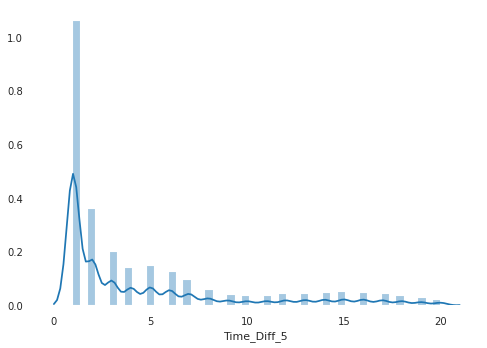

In [24]:
sns.distplot(message.Time_Diff_5)

In [25]:
print("Time Diff unique values: {}".format(len(message['Time_Diff_5'].unique())))
print("Type unique values: {}".format(len(message['Type'].unique())))
print("Direction unique values: {}".format(len(message['Direction'].unique())))
print("Size Int unique values: {}".format(len(message['Size_Int'].unique())))
print("Round Price unique values: {}".format(len(message['Round_Price_Times_10'].unique())))

Time Diff unique values: 20
Type unique values: 5
Direction unique values: 2
Size Int unique values: 12
Round Price unique values: 11


In [26]:
message.shape

(229706, 11)

In [27]:
message.head(100)

,Time,Type,OrderID,Size,Price,Direction,Time_Diff,Time_Diff_5,Real_Price,Round_Price_Times_10,Size_Int
0,34200.317290,4,16166187,100,309700,-1,0,1,30.97,310,1
1,34200.317290,4,16167006,100,309700,-1,0,1,30.97,310,1
2,34200.317290,4,16166170,100,309800,-1,0,1,30.98,310,1
3,34200.317290,1,3906511,100,310000,-1,0,1,31.00,310,1
4,34200.317290,1,4743470,100,310000,-1,0,1,31.00,310,1
...,...,...,...,...,...,...,...,...,...,...,...
95,34204.993718,4,16299435,100,310100,-1,0,1,31.01,310,1
96,34204.993718,4,16319638,100,310100,-1,0,1,31.01,310,1
97,34204.993830,1,16713161,100,310000,1,30,7,31.00,310,1
98,34205.032283,1,16716812,100,310200,1,75,16,31.02,310,1


In [ ]:
df = message[['Direction','Type','Size_Int','Time_Diff_5','Round_Price_Times_10']][0:100000]

In [ ]:
df.head()

In [ ]:
df.info()

## Feature Engineering

## Test the decode ability

In [ ]:
fea_columns = ['Direction','Type','Size_Int','Time_Diff_5','Round_Price_Times_10']
feature_encoder = OrdinalEncoder()
feature_encoder.fit(block[fea_columns])
new_block = block.copy()
new_block[fea_columns] = feature_encoder.transform(block[fea_columns])

In [ ]:

with open('OrdinalEncoder.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(feature_encoder, f)

In [ ]:
new_block.info()

In [ ]:
new_block = new_block.astype('int64')

In [ ]:
new_block.head()

In [ ]:
# #SIZE DIRECTION AND TYPE
# size_filter_list = list(range(100,1300,100))
# message_size = message[message['Size'].isin(size_filter_list)]
# message_size["Size"] = message_size["Size"].apply(lambda x: int(x/100))
# message_size['Size'].nunique()
# # message_size['Size'] = message_size['Size'].apply(str)
# test_block = message_size.loc[:,["Type","Size","Direction"]]
# # new_test_block = MultiColumnLabelEncoder(columns = ['Type','Size','Direction']).fit_transform(test_block)
# # new_test_block.head()
# test_block = test_block.reset_index(drop = True)
# size_block = test_block.iloc[0:10000,:]
# size_block.shape
# size_block.head()

In [ ]:
num_list = [j.nunique() for i,j in new_block.iteritems()]
print(num_list)
new_block['index'] = new_block.apply(encode_cat,axis = 1,cat_num_list = num_list)
new_block.head()

In [ ]:
shuffle_encoder = Shuffle_Transformer(list(new_block['index']))
shuffle_dict = shuffle_encoder.get_index_map()
new_block['shuffle_index'] = shuffle_encoder.get_shuffle(list(new_block['index']))

In [ ]:
with open('ShuffleEncoder.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(shuffle_encoder, f)

In [ ]:
new_block.to_csv("After_Process_Data.csv")

In [ ]:
new_block

### Output data to txt

In [ ]:
index_list = list(new_block["shuffle_index"])
def list_of_groups(init_list, childern_list_len):
    '''
    init_list为初始化的列表，childern_list_len初始化列表中的几个数据组成一个小列表
    :param init_list:
    :param childern_list_len:
    :return:
    '''
    list_of_group = zip(*(iter(init_list),) *childern_list_len)
    end_list = [list(i) for i in list_of_group]
    count = len(init_list) % childern_list_len
    end_list.append(init_list[-count:]) if count !=0 else end_list
    return end_list
index_sub = list_of_groups(index_list,20)
index_str = [" ".join(map(lambda x:str(x), i)) for i in index_sub]

with open('SeqGAN_input.txt', 'w') as filehandle:
    for listitem in index_str:
        filehandle.write('%s\n' % listitem)

## After SeqGan, Comparing the result

In [11]:
# Import Data
block = pd.read_csv('/kaggle/input/lob-msft/After_Process_Data.csv',index_col=0)

with open('/kaggle/input/lob-msft/ShuffleEncoder.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    shuffle_encoder = pickle.load(f)

with open('/kaggle/input/lob-msft/OrdinalEncoder.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    feature_encoder = pickle.load(f)    
    
#get output list
listOfLines = list()        
with open ("/kaggle/input/lob-msft/SeqGAN_output_may_7.txt", "r") as myfile:
    for line in myfile:
        listOfLines.append(line.strip()) 
output_list = []
for i in listOfLines:
    for s in i.split(' '):
        output_list.append(int(s))

In [12]:
block.head()

,Direction,Type,Size_Int,Time_Diff_5,Round_Price_Times_10,index,shuffle_index
0,0,3,0,0,4,4324,10803
1,0,3,0,0,4,4324,10803
2,0,3,0,0,4,4324,10803
3,0,0,0,0,4,4,7929
4,0,0,0,0,4,4,7929


In [114]:
print("Time Diff unique values: {}".format(len(block['Time_Diff_5'].unique())))
print("Type unique values: {}".format(len(block['Type'].unique())))
print("Direction unique values: {}".format(len(block['Direction'].unique())))
print("Size Int unique values: {}".format(len(block['Size_Int'].unique())))
print("Round Price unique values: {}".format(len(block['Round_Price_Times_10'].unique())))

Time Diff unique values: 20
Type unique values: 5
Direction unique values: 2
Size Int unique values: 12
Round Price unique values: 6


In [13]:
len(output_list)

199680

In [113]:
num_list

[2, 5, 12, 20, 6]

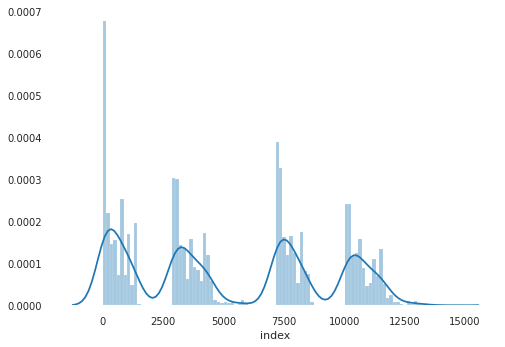

In [14]:
sns.distplot(block['index'], bins = 100)

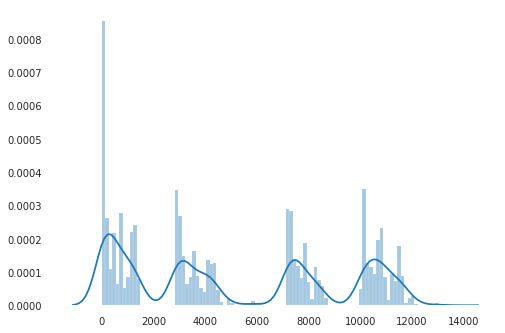

In [15]:
sns.distplot(np.array(output_list), bins = 100)

In [40]:
output_block = pd.DataFrame(columns = block.columns)

In [65]:
output_block['shuffle_index'] = np.array(output_list)
output_block['index'] = shuffle_encoder.get_inverse(list(output_block['shuffle_index']))

fea_columns = ['Direction','Type','Size_Int','Time_Diff_5','Round_Price_Times_10']

num_list = [j.nunique() for i,j in block[fea_columns].iteritems()]

output_block[fea_columns] = output_block['index'].apply(lambda x: pd.Series(decode_cat(x,cat_num_list = num_list)))

# for index, row in output_block.iterrows():
#     row['Direction','Type','Size_Int','Time_Diff_5','Round_Price_Times_10']=decode_cat(row['index'],num_list)
#     print(index)

In [110]:
output_block.shape

(199680, 7)

In [111]:
new_output_block.shape

(199680, 7)

In [69]:
new_output_block = output_block.copy()
new_output_block[fea_columns] = feature_encoder.inverse_transform(output_block[fea_columns])

In [84]:
new_block = block.copy()
new_block[fea_columns] = feature_encoder.inverse_transform(block[fea_columns])

In [71]:
new_output_block.to_csv('Synthetic_Data.csv')

## Data Analysis

In [101]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec

### Direction

Text(0.5, 0.98, 'Direction Comparison')

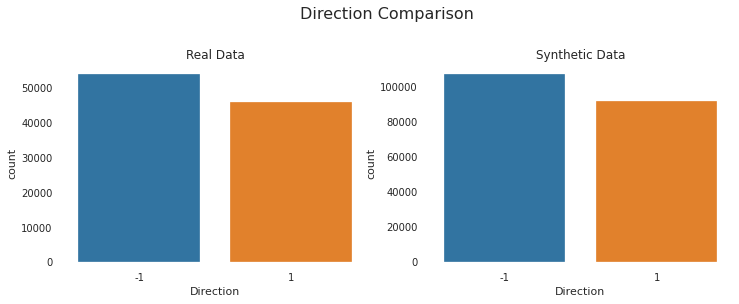

In [121]:
plt.figure(2, figsize=(12,8))
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 0],  title='Real Data')
sns.countplot(x='Direction',data=new_block)

plt.subplot(the_grid[0, 1], title='Synthetic Data')
sns.countplot(x='Direction', data=new_output_block)

plt.suptitle('Direction Comparison', fontsize=16)

Text(0.5, 0.98, 'Type Comparison')

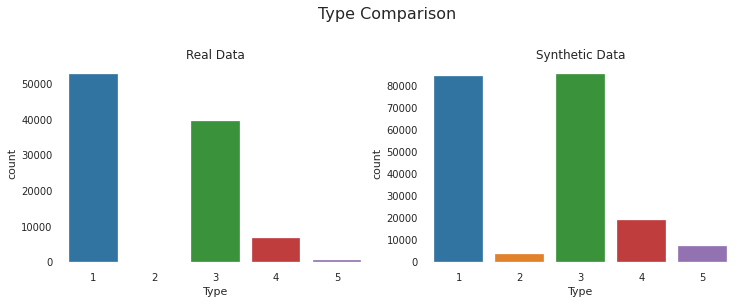

In [117]:
plt.figure(2, figsize=(12,8))
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 0],  title='Real Data')
sns.countplot(x='Type',data=new_block)

plt.subplot(the_grid[0, 1], title='Synthetic Data')
sns.countplot(x='Type', data=new_output_block)

plt.suptitle('Type Comparison', fontsize=16)

Text(0.5, 0.98, 'Size Comparison *100')

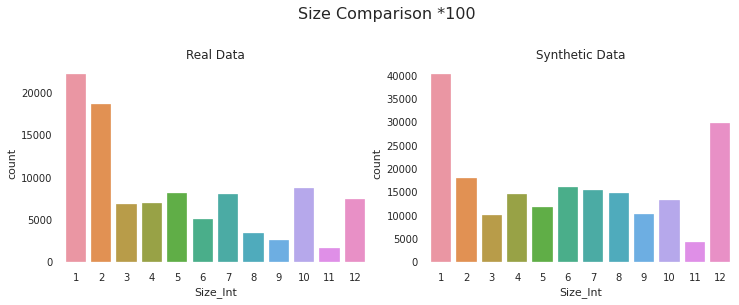

In [118]:
plt.figure(2, figsize=(12,8))
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 0],  title='Real Data')
sns.countplot(x='Size_Int',data=new_block)

plt.subplot(the_grid[0, 1], title='Synthetic Data')
sns.countplot(x='Size_Int', data=new_output_block)

plt.suptitle('Size Comparison *100', fontsize=16)

Text(0.5, 0.98, 'Time Differenence Comparison (0.000001s)')

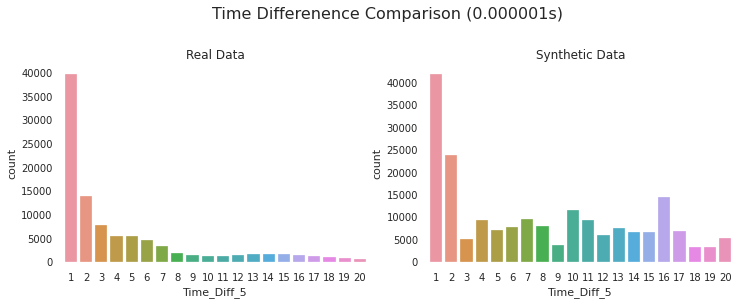

In [120]:
plt.figure(2, figsize=(12,8))
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 0],  title='Real Data')
sns.countplot(x='Time_Diff_5',data=new_block)

plt.subplot(the_grid[0, 1], title='Synthetic Data')
sns.countplot(x='Time_Diff_5', data=new_output_block)

plt.suptitle('Time Differenence Comparison (0.000001s)', fontsize=16)

Text(0.5, 0.98, 'Pie Consumption Patterns in the United States')

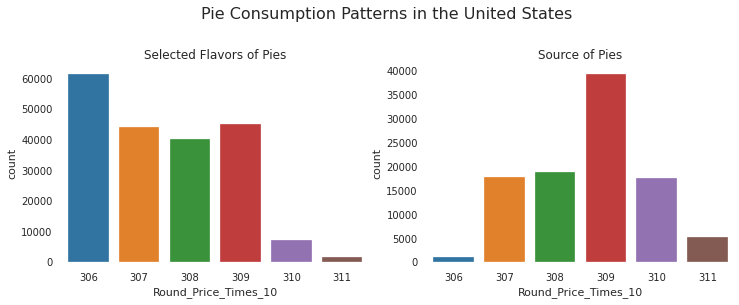

In [112]:
plt.figure(2, figsize=(12,8))
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 1],  title='Source of Pies')
sns.countplot(x='Round_Price_Times_10',data=new_block)

plt.subplot(the_grid[0, 0], title='Selected Flavors of Pies')
sns.countplot(x='Round_Price_Times_10', data=new_output_block)

plt.suptitle('Pie Consumption Patterns in the United States', fontsize=16)

# Old One

In [ ]:
fig = px.pie(size_block,names='Size')
fig.show()

In [ ]:
listOfLines = list()        
with open ("/kaggle/input/lob-msft/SeqGAN_input.txt", "r") as myfile:
    for line in myfile:
        listOfLines.append(line.strip()) 

input_list = []
for i in listOfLines:
    for s in i.split(' '):
        input_list.append(int(s))
len(input_list)

In [ ]:
#get output list
listOfLines = list()        
with open ("/kaggle/input/lob-msft/SeqGAN_output.txt", "r") as myfile:
    for line in myfile:
        listOfLines.append(line.strip()) 
output_list = []
for i in listOfLines:
    for s in i.split(' '):
        output_list.append(int(s))

In [ ]:
num_list = [j.nunique() for i,j in test_block.iteritems()]
num_list

In [ ]:
fake_data = size_block.copy()
fake_data.head()
small_output_list = sample(output_list,10000)
#update the output_list to a-list
fake_data['index'] = small_output_list
fake_data.head()
for index, row in fake_data.iterrows():
    row["Type","Size","Direction"]=decode_cat(row['index'],num_list) 
fake_data.head()
    
#fake_data[["Type","Size","Direction"]] = fake_data['index'].apply(decode_cat,cat_num_list = num_list)
# len(output_list)

In [ ]:
fig = px.pie(fake_data,names='Size')
fig.show()

# Data Analysis

In [ ]:
message.head()

In [ ]:
message["Price"]= message["Price"]/10000
message.head()

In [ ]:
#pandas_profiling.ProfileReport(message)
message.shape
fig = px.pie(message,names='Type')
fig.show()

In [ ]:
fig = px.pie(message,names='Size')
fig.show()

In [ ]:
fig = px.pie(fake_data,names='Type')
fig.show()

In [ ]:
fig = px.pie(message,names='Direction')
fig.show()

In [ ]:
fig = px.pie(fake_data,names='Direction')
fig.show()

In [ ]:
ax = sns.distplot(message['Price'])

In [ ]:
message["Price"].describe()

In [ ]:
message['time_diff'] = message.Time.diff()
message.head()
message['time_diff'].describe()

In [ ]:
a = message[message['time_diff']<0.0002]
a['time_diff'] = a['time_diff']*100000

ax1 = sns.distplot(a['time_diff'])

In [ ]:
a.describe()

In [ ]:
#SIZE DIRECTION AND TYPE
size_filter_list = list(range(100,1300,100))
message_size = message[message['Size'].isin(size_filter_list)]
message_size["Size"] = message_size["Size"].apply(lambda x: int(x/100))
message_size['Size'].nunique()
# message_size['Size'] = message_size['Size'].apply(str)
test_block = message_size.loc[:,["Type","Size","Direction","Price"]]
new_test_block = MultiColumnLabelEncoder(columns = ['Type','Size','Direction','Price']).fit_transform(test_block)
new_test_block.head()

In [ ]:
num_list = [j.nunique() for i,j in new_test_block.iteritems()]
output_chunk = new_test_block.iloc[1:10000,:]
output_chunk['index'] = output_chunk.apply(encode_cat,axis = 1,cat_num_list = num_list)
output_chunk.head()

In [ ]:
ax = sns.distplot(output_chunk["index"])